In [6]:
using Unitful
using UnitfulUS

In [65]:
# Register jupyter notebook as a source of units 
# for new units we define
Unitful.register(Main);
@unit HP "HP" Horsepower 0.7456999*u"kW" false
@unit cc "cc" CubicCentimeter 1u"cm^3" false
@unit ci "ci" CubicInch 1u"inch^3" false
@derived_dimension VolumeFlow  Unitful.𝐋^3 / Unitful.𝐓
@derived_dimension EnergyDensity Unitful.𝐋^2*Unitful.𝐌*Unitful.𝐓^-2/Unitful.𝐌

## AFR / Lambda & Fuel Blends

In [66]:
struct Fuel 
    lhv::EnergyDensity # lower heating value
    octane::Real
    density::Unitful.Density
    stoic_afr::Real
end

const GasRegular = Fuel(42.7u"kJ/kg", 87, 0.74u"kg/l", 14.8);
const GasPremium = Fuel(43.5u"kJ/kg", 93, 0.755u"kg/l", 14.7);
const Methanol =   Fuel(19.7u"kJ/kg", 104.5, 0.79u"kg/l", 6.47);
const Ethanol =    Fuel(26.8u"kJ/kg", 104.2, 0.79u"kg/l", 9.0);
const E85     =    Fuel(29.19u"kJ/kg",101.6, 0.783u"kg/l", 9.87);

In [67]:
λ(afr::Real, afr_stoic::Real) = afr / afr_stoic;
λ(afr::Real, fuel::Fuel=GasPremium) = afr / fuel.stoic_afr;
afr(λ::Real, fuel::Fuel=GasPremium) = λ * fuel.stoic_afr;
afr(λ::Real, afr_stoic::Real) = λ * afr_stoic;

In [68]:
λ(12.0)

0.8163265306122449

In [69]:
λ(14.7, E85)

1.4893617021276597

## Boost and Power

In [59]:
"""
Garbage calculation grabbed from: https://bit.ly/3oUG6sA
"""
function air_needs(hp_goal::Unitful.Power, 
        afr::Real, 
        bsfc)
    # mass_air_flow = air lbs / minute
    mass_air_flow = hp_goal * afr * (bsfc |> u"lbf/hr/HP") # power * air / fuel * (fuel/min) / power = 
    return mass_air_flow;
end
function boost_needs(hp_goal::Unitful.Power, 
        afr::Real, 
        bsfc, 
        charge_temp::Unitful.Temperature, 
        ve::Real, 
        max_rpm::Unitful.Frequency, 
        displacement::Unitful.Volume)
    mass_air_flow = air_needs(hp_goal, afr, bsfc) |> u"lbf/minute";
    gas_constant_r = 639.6u"inch^3/Ra/inch^2";
    charge_temp_absolute = charge_temp |> u"Ra"; # absolute Rankine/Fahrenheit
    # MAPreq = [(R*Wa*(460+Tm)]/(Vd*N/2*VE)
    # top is volume flow rate - MAF * temp correction factor using ideal gas law
    # PV/t = N/tRT - pressure * volume
    # units - lbs/min * ? * Ra = PSI*in^3/min
    required_pressure_top = mass_air_flow * gas_constant_r * charge_temp_absolute |> u"psi * cc / minute";
    # bottom is air capacity per time - cc/min - divide by 2 revolutions per fill for 4 stroke
    required_pressure_bot = displacement * max_rpm / 2π*u"rad" / 2 * ve;
    required_MAP = required_pressure_top / required_pressure_bot;
    boost = required_MAP - 1u"atm";
    return boost |> u"psi";
end

boost_needs (generic function with 1 method)

In [60]:
boost_needs(150u"HP", 
    12.0, 
    0.6u"lbf/hr/HP", 
    130u"°F", 
    0.95, 
    6000u"rpm", 
    1756u"cc"
)

7.533145701665479 psi

In [44]:
1u"rpm" |> u"Hz"

0.10471975511965977 Hz

In [45]:
10u"psi / minute / rpm" |> u"psi"

1.5915494309189535 psi

In [14]:
air_needs(150u"HP", 12.0, 0.6u"lbf/hr/HP") |> u"lbf/minute"

18.0 lbf minute⁻¹

## Plots

In [13]:
using Plots
using UnitfulRecipes

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling UnitfulRecipes [42071c24-d89e-48dd-8a24-8a12d9b8861f]
└ @ Base loading.jl:1423


In [14]:
bsfc_range = range(0.3u"lbf/hr/HP",0.7u"lbf/hr/HP",100);
boost_per_bsfc = map(x->boost_needs(150u"HP", 12.0, x, 130u"°F", 0.95, 6000u"rpm", 1756u"cc"), bsfc_range);

In [15]:
boost_per_bsfc

100-element Vector{Quantity{Float64, 𝐌 𝐋⁻¹ 𝐓⁻², Unitful.FreeUnits{(psi,), 𝐌 𝐋⁻¹ 𝐓⁻², nothing}}}:
  -12.92701364226356 psi
  -12.90318960006491 psi
 -12.879365557866256 psi
 -12.855541515667605 psi
 -12.831717473468954 psi
 -12.807893431270301 psi
  -12.78406938907165 psi
 -12.760245346872999 psi
 -12.736421304674346 psi
 -12.712597262475695 psi
 -12.688773220277042 psi
 -12.664949178078391 psi
  -12.64112513587974 psi
                       ⋮
  -10.83049792878221 psi
  -10.80667388658356 psi
 -10.782849844384906 psi
 -10.759025802186256 psi
 -10.735201759987604 psi
 -10.711377717788952 psi
   -10.6875536755903 psi
  -10.66372963339165 psi
 -10.639905591192996 psi
 -10.616081548994345 psi
 -10.592257506795695 psi
  -10.56843346459704 psi

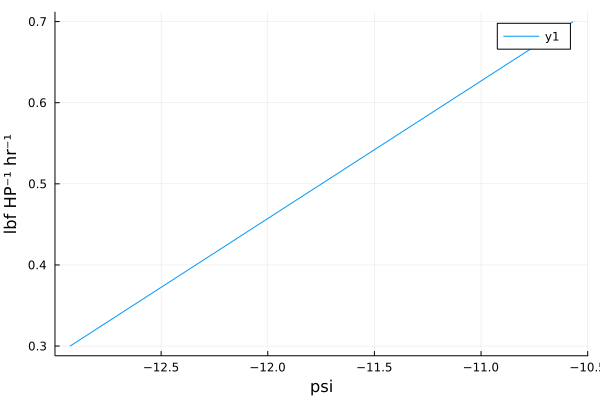

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


In [16]:
plot(boost_per_bsfc, bsfc_range)

In [58]:
hp_range = range(100u"HP", 200u"HP", 100);
boost_per_hp = map(x->boost_needs(x, 12.0, 0.6u"lbf/hr/HP", 130u"°F", 0.95, 6000u"rpm", 1756u"cc"), hp_range);

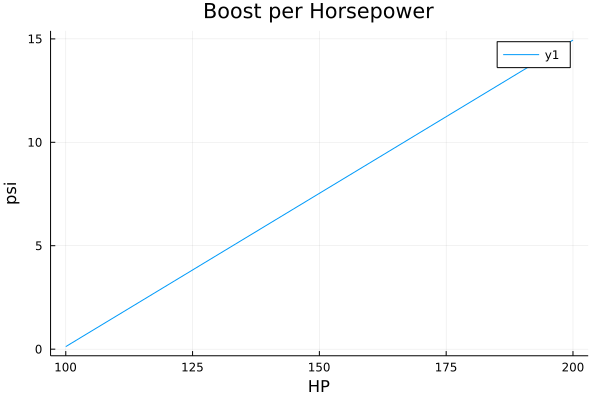

In [61]:
plot(hp_range, boost_per_hp, title="Boost per Horsepower")

In [67]:
iat_range = range(0u"°F" |> u"Ra", 200u"°F" |> u"Ra", 100)
boost_per_iat = map(x->boost_needs(150u"HP", 12.0, 0.6u"lbf/hr/HP", x, 0.95, 6000u"rpm", 1756u"cc"), iat_range);

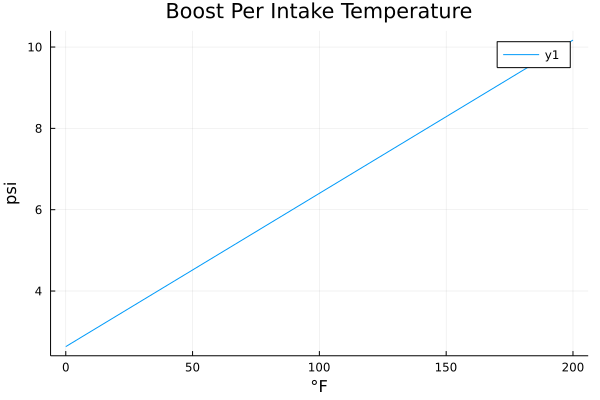

In [70]:
plot(map(u"°F", iat_range), boost_per_iat, title="Boost Per Intake Temperature")